### PSF Gaussian Fitting example

In [20]:
import numpy as np
#from toolviper.utils.data import download
#download(file="twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf.zip")
#tar xvf twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf.zip

Load a CASA psf image

In [21]:
from xradio.image import read_image
xds = read_image(infile='twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf', chunks={"l":25, "m":25, "frequency":4} )

[2025-09-08 14:32:47,315]     INFO    viperlog:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf: 1 columns, 1 rows
[2025-09-08 14:32:47,320]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


In [22]:
xds.BEAM

<xarray.DataArray 'BEAM' (time: 1, frequency: 11, polarization: 1, beam_param: 3)> Size: 264B
dask.array<array, shape=(1, 11, 1, 3), dtype=float64, chunksize=(1, 11, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 8B 5.625e+04
  * frequency     (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization  (polarization) <U1 4B 'I'
    velocity      (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
  * beam_param    (beam_param) <U5 60B 'major' 'minor' 'pa'
Attributes:
    units:    rad

Run gaussian fit on the psf in xradio image format

In [23]:
from astroviper.core.image_analysis.psf_gaussian_fit import psf_gaussian_fit
psf_gaussian_fit?

Signature:
psf_gaussian_fit(
    xds,
    dv='SKY',
    npix_window=[9, 9],
    sampling=[9, 9],
    cutoff=0.35,
)
Docstring:
fit 2D gaussian to psf

Parameters
----------
xds : xarray.Dataset
    The input data cube.
dv : str
    The data variable to fit. Default is 'SKY'.
npix_window : list
    The size of the fitting window in pixels.
sampling : list
    The sampling of the fitting grid.
cutoff : float
    The cutoff value for the fitting.

Returns
-------
xds : xarray.Dataset
    The image with the fitted parameters added.
    The unit of beam size (major and minor) will be the same unit as
    that of the input image. If there is no unit attribute for the
    input image, the unit will be radian. The position angle is given
    in degrees.
File:      ~/SWDevel/radps/viper/sandbox/astroviper/src/astroviper/core/image_analysis/psf_gaussian_fit.py
Type:      function

In [24]:
res_xds = psf_gaussian_fit(xds,npix_window=(21,21), sampling=(21,21))

(1, 11, 1, 3)


In [25]:
res_xds.BEAM

<xarray.DataArray 'BEAM' (time: 1, frequency: 11, polarization: 1, beam_param: 3)> Size: 264B
dask.array<array, shape=(1, 11, 1, 3), dtype=float64, chunksize=(1, 11, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 8B 5.625e+04
  * frequency     (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization  (polarization) <U1 4B 'I'
    velocity      (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
  * beam_param    (beam_param) <U5 60B 'major' 'minor' 'pa'
Attributes:
    units:    rad

In [26]:
data_sel = {'time':[0], 'polarization':[0], 'frequency':[0]}

bmaj=2.6214203167700385e-06,bmin=2.1205892648113387e-06, bpa=30.86190414428711


'rad'

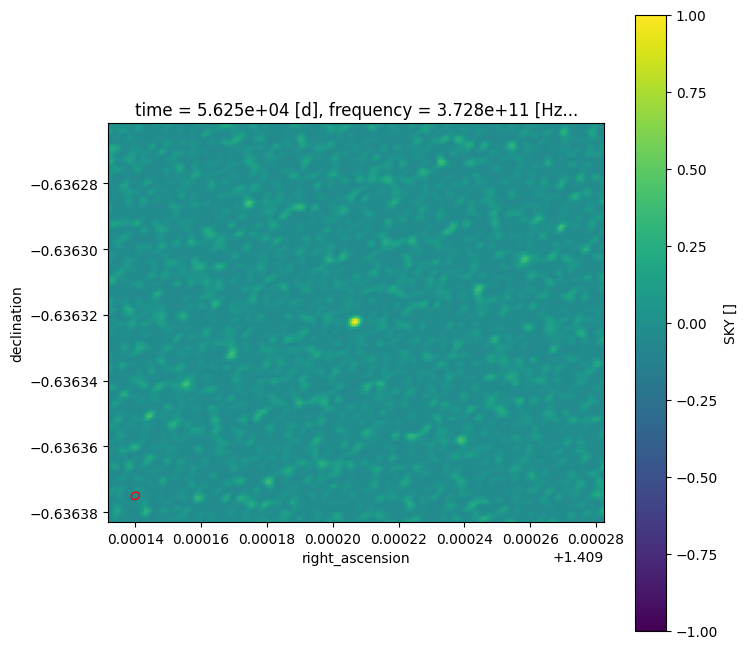

In [27]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

data1 = xds.SKY.isel(data_sel).squeeze().T
#
fig, ax = plt.subplots(figsize=(8,8))
data1.plot.pcolormesh(x='right_ascension', y='declination', ax=ax, cmap='viridis', add_colorbar=True)
bmaj = xds.BEAM.isel(data_sel).data.compute()[0,0,0][0]
bmin = xds.BEAM.isel(data_sel).data.compute()[0,0,0][1]
bpa = np.rad2deg(xds.BEAM.isel(data_sel).data.compute()[0,0,0][2])
print(f'bmaj={bmaj},bmin={bmin}, bpa={bpa}')
from matplotlib.patches import Ellipse

beam = Ellipse(
    (1.40914,-0.636375),
    width=bmaj,
    height=bmin,
    angle=bpa,
    color='red',
    lw=1,
    fill=False,
    zorder=10 # Ensure the ellipse is drawn on top
)
ax.add_patch(beam)
ax.set_aspect('equal', adjustable='box')
xds.BEAM.attrs['units']

In [28]:
from xradio.image import write_image

In [29]:
write_image(res_xds, "fitted_beam.im", out_format="casa",overwrite=True)

[2025-09-08 14:32:53,577]  WARNING    viperlog:  Because overwrite=True, removing existing path fitted_beam.im 


### Compare the fitting result with one provided in the input image

In [30]:
# Generate 2D gaussian based on the beam parameters
def psf_model(xds, data_sel, beam_param):
    wx, wy, rot = beam_param
    print(f"bmaj:{wx}, bmin:{wy}, pa:{rot}")
    l = xds.SKY.isel(data_sel).l.data
    m = xds.SKY.isel(data_sel).m.data
    X, Y = np.meshgrid(l,m)
    xp = X*np.cos(rot) + Y*np.sin(rot)
    yp = X*np.sin(rot) - Y*np.cos(rot)
    gaussian = 1.0 * np.exp(-(((xp) / wx) ** 2 + ((yp) / wy) ** 2) / 2.0)
    return gaussian

In [31]:
model = psf_model(xds, data_sel,res_xds.BEAM.isel(data_sel).data.compute().squeeze())

bmaj:2.6208489888505924e-06, bmin:2.1317434921848332e-06, pa:0.558018076526561


In [32]:
casa_model = psf_model(xds, data_sel, xds.BEAM.isel(data_sel).data.compute().squeeze())

bmaj:2.6214203167700385e-06, bmin:2.1205892648113387e-06, pa:0.5386418407526932


In [33]:
beam_param = res_xds.BEAM.data.compute()
bmajs = beam_param[:,:,:].squeeze().T[0]
bmins = beam_param[:,:,:].squeeze().T[1]
pas = beam_param[:,:,:].squeeze().T[2]
casa_beam_param = xds.BEAM.data.compute()
casa_bmajs = casa_beam_param[:,:,:].squeeze().T[0]
casa_bmins = casa_beam_param[:,:,:].squeeze().T[1]
casa_pas = casa_beam_param[:,:,:].squeeze().T[2]

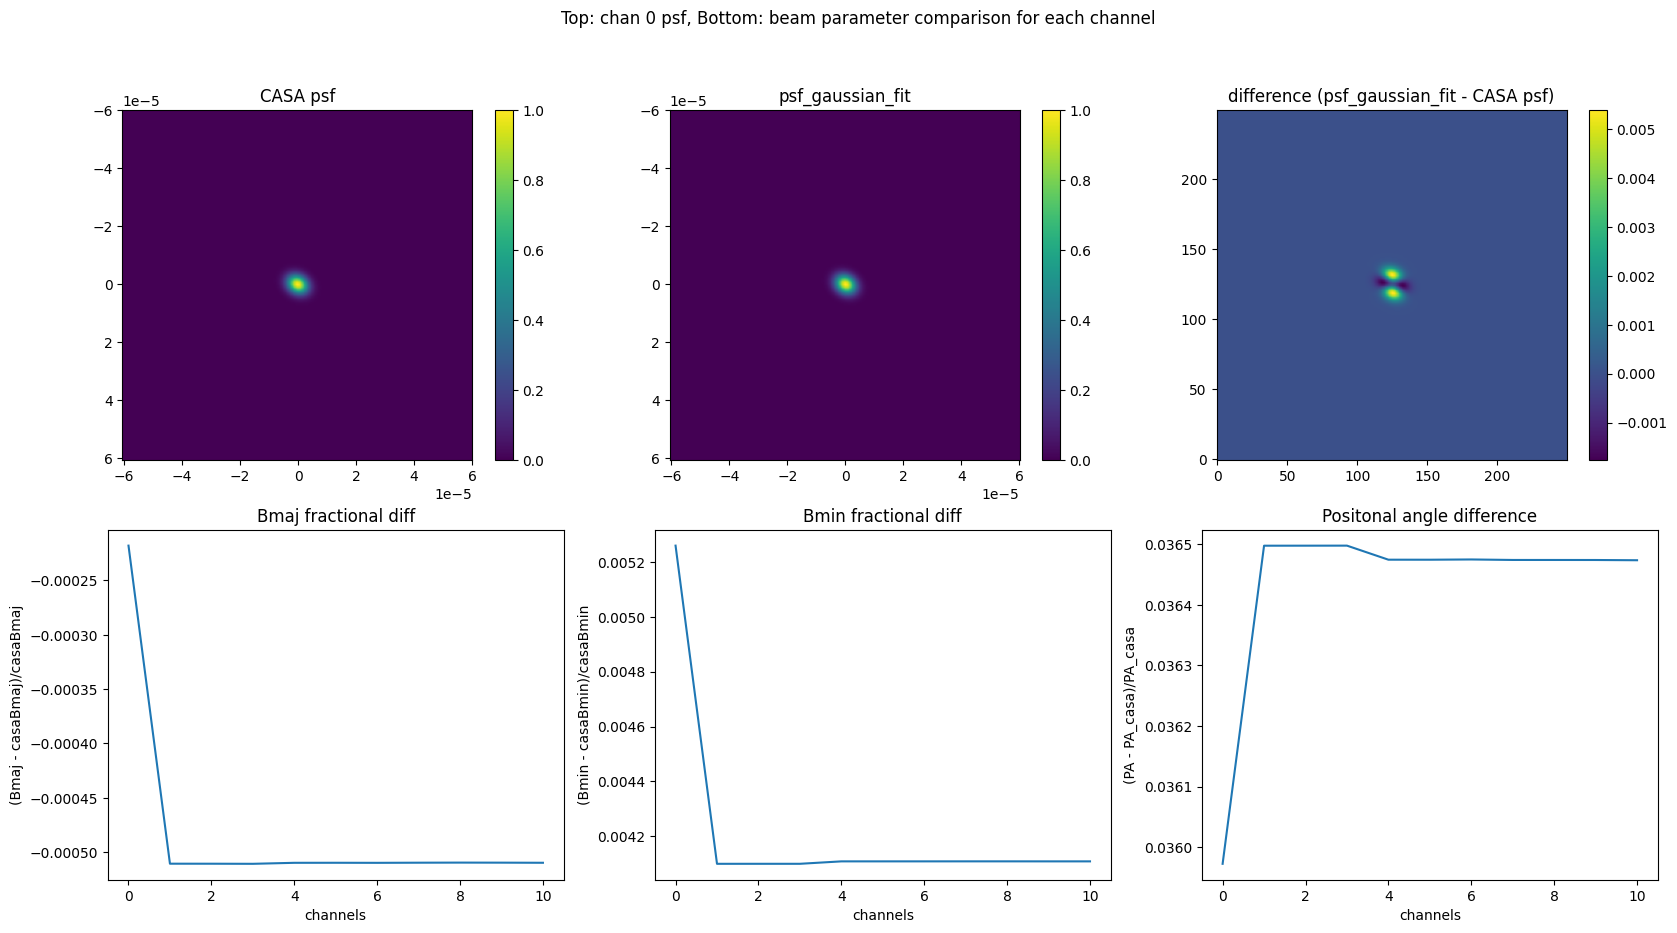

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
l = xds.SKY.isel(data_sel).l.data
m = xds.SKY.isel(data_sel).m.data
extent=(m[0], m[-1], l[0], l[-1])
im1 = axes[0, 0].imshow(casa_model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im1, ax=axes[0,0])
axes[0, 0].set_title("CASA psf")
im2 = axes[0, 1].imshow(model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im2, ax=axes[0,1])
axes[0,1].set_title("psf_gaussian_fit")
im3 = axes[0,2].imshow( (model - casa_model), origin='lower', cmap='viridis')
axes[0,2].set_title("difference (psf_gaussian_fit - CASA psf)")
plt.colorbar(im3, ax=axes[0,2])
#im_data = xds.SKY.isel(data_sel).data.compute().squeeze()#
#X, Y = np.meshgrid(l,m)
#x_cen = int(len(l)/2)
#y_cen = int(len(m)/2)
chans = np.arange(beam_param.shape[1])
axes[1,0].plot(chans, (bmajs - casa_bmajs)/bmaj)
axes[1,0].set_ylabel("(Bmaj - casaBmaj)/casaBmaj")
axes[1,0].set_xlabel("channels")
axes[1,0].set_title("Bmaj fractional diff")
axes[1,1].plot(chans, (bmins - casa_bmins)/casa_bmins)
axes[1,1].set_ylabel("(Bmin - casaBmin)/casaBmin")
axes[1,1].set_xlabel("channels")
axes[1,1].set_title("Bmin fractional diff")
#axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
axes[1,2].set_ylabel("(PA - PA_casa)/PA_casa")
axes[1,2].set_xlabel("channels")
axes[1,2].set_title("Positonal angle difference")
axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
fig.suptitle("Top: chan 0 psf, Bottom: beam parameter comparison for each channel")
plt.show()